# Setup

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

import seaborn as sns

# sns.set(style='whitegrid')

In [2]:
class KArmedBandit:
    def __init__(self, k=10):
        
        self.k = k
        self.action_values = np.random.standard_normal(size=self.k)

    def graph(self):        
        
        rewards = [np.random.normal(av, 1, size=5000) for av in self.action_values]  # used for graphing only
        
        temp_df = pd.DataFrame({'q*': self.action_values, 'reward_dist': rewards})
        temp_df = pd.DataFrame({
                  col:np.repeat(temp_df[col].values, temp_df['reward_dist'].str.len())
                  for col in temp_df.columns.drop('reward_dist')}).assign(**{'reward_dist':np.concatenate(temp_df['reward_dist'].values)})[temp_df.columns]
        
        ax = sns.violinplot(x='q*', y='reward_dist', data=temp_df, order=self.action_values)
        ax.set(xlabel='Action', ylabel='Reward Distribution')
        ax.set_xticklabels(np.arange(0, self.k))
        
    def give_reward(self, action):
        return np.random.normal(self.action_values[action], 1)
        

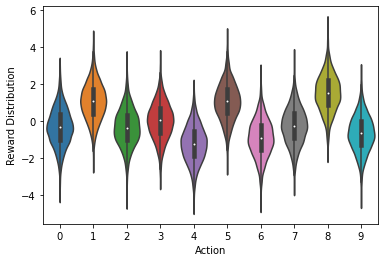

In [3]:
K = 10
bandit = KArmedBandit(K)
bandit.graph()  # The agent does not have this knowledge

Next, several methods for discovering the optimal action will be implemented.

# Helper Functions

In [4]:
# Similar to np.argmax, but provides all indices instead of only the first.
# https://stackoverflow.com/questions/17568612/how-to-make-numpy-argmax-return-all-occurrences-of-the-maximum

def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

# Greedy Policy

The agent will always choose the best action (indicated by the largest q-value in q_values). If multiple actions give the same reward, an action will be chosen randomly and uniformly.

See Sutton & Barto 2.4 for incremental update derivation.

In [5]:
STEPS = 50_000

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    greedy_action = np.random.choice(allmax(q_values))
    
    action_count[greedy_action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(greedy_action)
    q_values[greedy_action] = q_values[greedy_action] + (1/action_count[greedy_action]) * (reward - q_values[greedy_action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 0.0
ACTION: 1 	 Q-VALUE: 0.0
ACTION: 2 	 Q-VALUE: 0.0
ACTION: 3 	 Q-VALUE: 0.0
ACTION: 4 	 Q-VALUE: 0.0
ACTION: 5 	 Q-VALUE: 0.0
ACTION: 6 	 Q-VALUE: 0.0
ACTION: 7 	 Q-VALUE: 0.0
ACTION: 8 	 Q-VALUE: 1.5524526490365105
ACTION: 9 	 Q-VALUE: -0.827525245153383
BEST ACTION: 8


Clearly, some actions are never even tried. In this example, once a single Q-value becomes greater than 0, it is chosen 100% of the time. This lack of exploration can mean that the optimal action is never discovered by the agent. One common solution to this is to introduce epsilon, a small probability of randomly choosing uniformly between all actions, regardless of action-value. This 'epsilon-greedy' method will be implemented below.

# Epsilon-Greedy Policy

Frequently, the agent chooses the best action, similar to the greedy policy above. However, for a small probability epsilon, the agent randomly selects among all actions uniformly.

In [6]:
STEPS = 50_000
EPSILON = 0.01  # random action is chosen 1% of the time

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    prob = np.random.rand()
    
    if prob >= EPSILON:  # greedy
        action = np.random.choice(allmax(q_values))
    
    else:  # exploration
        action = np.random.choice(np.arange(0, K))
    
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + (1/action_count[action]) * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: -0.4451690652678447
ACTION: 1 	 Q-VALUE: 1.085685239599992
ACTION: 2 	 Q-VALUE: -0.2614175442261148
ACTION: 3 	 Q-VALUE: 0.024811712570456224
ACTION: 4 	 Q-VALUE: -1.3582344255235261
ACTION: 5 	 Q-VALUE: 1.0365594098885353
ACTION: 6 	 Q-VALUE: -0.5746719065268465
ACTION: 7 	 Q-VALUE: -0.14663911939511953
ACTION: 8 	 Q-VALUE: 1.554276125075991
ACTION: 9 	 Q-VALUE: -0.7327311097049574
BEST ACTION: 8


The optimal action is found with more certainty. Also, all actions are now being tried.

Other additions to a solution include optimistic initial value selection, upper-confidence-bound action selection, and support for nonstationary problems. These ideas will be implemented below.

# Optimistic Initial Value Selection

If we have an idea of possible rewards the agent can receive, we can initialize our Q-values in a way that encourages exploration. If all actions initially appear excellent, once one is updated closer to its actual worth, the other untested actions are still contenders in a greedy scenario. However, this alone is not sufficient in general, and particularly for nonstationary problems. See Sutton & Barto 2.6 for more information about potential benefits and drawbacks.

This method will be implemented with a greedy policy.

In [7]:
STEPS = 50_000

q_values = np.full((K, ), 7, dtype=np.float)  # initialize q_values to an array of 7s instead of 0s
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    greedy_action = np.random.choice(allmax(q_values))
    
    action_count[greedy_action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(greedy_action)
    q_values[greedy_action] = q_values[greedy_action] + (1/action_count[greedy_action]) * (reward - q_values[greedy_action])

for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: -1.3223408213518812
ACTION: 1 	 Q-VALUE: 1.09428646768898
ACTION: 2 	 Q-VALUE: 0.8762119622106894
ACTION: 3 	 Q-VALUE: -0.7745862047128247
ACTION: 4 	 Q-VALUE: -1.4733419057892103
ACTION: 5 	 Q-VALUE: 0.873582197670242
ACTION: 6 	 Q-VALUE: -1.4626973155654053
ACTION: 7 	 Q-VALUE: 0.30313757142431097
ACTION: 8 	 Q-VALUE: 0.25065510240840805
ACTION: 9 	 Q-VALUE: -0.6412391941013569
BEST ACTION: 1


All actions are tried-- an improvement over the greedy policy. But, as more steps are taken, less exploration occurs. Also, the optimal action is sometimes not found after the predetermined 50,000 steps.

# Upper-Confidence-Bound Action Selection

This method selects among actions "according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates" (Sutton & Barto 2.7). Usually performs well, but is difficult to extend beyond bandits to nonstationary problems. Large state spaces also pose an issue.

In [8]:
STEPS = 50_000
C = 2  # controls the degree of exploration

q_values = np.zeros(K)
action_count = np.ones(K)  # number of times an action has been selected, required to update q-value. initialize to 1s to avoid divide-by-zero errors.

for step in range(1, STEPS+1):
    
    temp_arr = [q_values[a] + C * np.sqrt(np.log(step) / action_count[a]) for a in np.arange(0, K)]
    
    action = np.argmax(temp_arr)
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + (1/action_count[action]) * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: -0.2185189567315484
ACTION: 1 	 Q-VALUE: 1.1936970248023138
ACTION: 2 	 Q-VALUE: -0.32772335738414593
ACTION: 3 	 Q-VALUE: -0.02233291717400309
ACTION: 4 	 Q-VALUE: -1.4293731326817736
ACTION: 5 	 Q-VALUE: 0.9131610232534042
ACTION: 6 	 Q-VALUE: -1.3280345456754084
ACTION: 7 	 Q-VALUE: -0.4892741275863868
ACTION: 8 	 Q-VALUE: 1.5464445228022674
ACTION: 9 	 Q-VALUE: -1.1552002709111984
BEST ACTION: 8


Unlike epsilon-greedy methods which can take a long time to explore, UCB can examine an action's potential. Many real-world bandit problems have been solved using UCB.

# Nonstationary Problems

Nonstationary problems are very common in RL. In nonstationary problems, the reward distribution does not stay the same. To account for this, more weight is given to recent rewards. This is accomplished by using a constant step-size parameter alpha.

The epsilon-greedy policy will be updated below to include this.

In [9]:
STEPS = 50_000
EPSILON = 0.01  # random action is chosen 1% of the time
ALPHA = 0.1  # constant step-size

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    prob = np.random.rand()
    
    if prob >= EPSILON:  # greedy
        action = np.random.choice(allmax(q_values))
    
    else:  # exploration
        action = np.random.choice(np.arange(0, K))
    
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + ALPHA * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: -0.21086644082648132
ACTION: 1 	 Q-VALUE: 0.7937105775309088
ACTION: 2 	 Q-VALUE: 0.12663938022822813
ACTION: 3 	 Q-VALUE: 0.1586736121307336
ACTION: 4 	 Q-VALUE: -1.2747727536496545
ACTION: 5 	 Q-VALUE: 0.715947724046595
ACTION: 6 	 Q-VALUE: -1.1558092538839404
ACTION: 7 	 Q-VALUE: -0.384452836839172
ACTION: 8 	 Q-VALUE: 1.787095740245316
ACTION: 9 	 Q-VALUE: -0.3947995388112514
BEST ACTION: 8


# Gradient Bandit Algorithms

To be continued...